**Objetivo del Notebook:** Buscar la combinación de ciclos ```for``` más eficiente en términos de duración al momento de cortar los parches.

Función a estudiar: ```extraccion_parches(self,Var, dx=dx)```

- orden por default:  (1) lat, (2) long, (3) tiempo.

In [1]:
import xarray as xr
import tensorflow as tf
import glob
import os
import numpy as np
from tqdm import tqdm

dx=32
def extraccion_parches(self,Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''
    
    stack = tf.stack([],axis=0)

    #recorremos en el tiempo
    for dt in tqdm(range(0,38)):
        #recorremos en la latitude
        for dlat in range(0,401-dx,dx):
                #recorremos en la longitude
            for dlong in range(0,101-dx,dx):  
                #Cortamos parches de 32x32 en 3 tiempos             
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 
    print("Stack patches shape: ",patches.shape)               
    return patches

##### Preparación del Setup:

In [2]:
import readNCdata as nc

#target
era5 = nc.NCFile('era5-land_*.nc', path='./Data/observed/2006/')
era5.setVar('t2m')
era5.loadVar()

#input
g05 = nc.NCFile('GFS0.5_t2m_heightAboveGround_instant_200610*.nc', path='./Data/forecasted/2006/2006101000/')
g05.setVar('t2m')
g05.loadVar()

g05.upscaleVar(era5.values)

c:\Users\ruben\anaconda3\envs\dwn_104\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.DataArray 't2m' (valid_time: 40, latitude: 401, longitude: 101)>
dask.array<copy, shape=(40, 401, 101), dtype=float32, chunksize=(40, 401, 101), chunktype=numpy.ndarray>
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float32 -15.0 -15.1 -15.2 ... -54.9 -55.0
  * longitude          (longitude) float32 -75.0 -74.9 -74.8 ... -65.1 -65.0
  * valid_time         (valid_time) datetime64[ns] 2006-10-10 ... 2006-10-14T...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

Idea: Imitar la estructura de la función ```extraccion_parches(self,Var, dx=dx)``` pero considerando distintas combinaciones de los ciclos ```for```:

- Tipo 1.1: Time / Lat / Long

In [3]:
import time
dx=32
def Patches_Time_Lat_Long(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)

    #recorremos en el tiempo
    for dt in range(0,38):
        #recorremos en la latitude
        for dlat in range(0,401-dx,dx):
                #recorremos en la longitude
            for dlong in range(0,101-dx,dx):  
                #Cortamos parches de 32x32 en 3 tiempos             
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [4]:
inp_TiLaLo,   dt_inp_TiLaLo = g05.Patches_Time_Lat_Long(Var=g05.getVar())
target_TiLaLo,dt_target_TiLaLo =era5.Patches_Time_Lat_Long(Var=era5.getVar())
lat_TiLaLo,   dt_lat_TiLaLo = era5.sampleLat_Time_Lat_Long()
lon_TiLaLo,   dt_lon_TiLaLo = era5.sampleLon_Time_Lat_Long()
orog_TiLaLo,  dt_orog_TiLaLo = era5.sampleBand1_Time_Lat_Long()
time1_TiLaLo, dt_time1_TiLaLo, time2_TiLaLo, dt_time2_TiLaLo = era5.sampleDayOfYear_Time_Lat_Long()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  168.21370220184326
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  9.003268003463745
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  3.932382583618164
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  3.859768867492676
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  6.080328464508057
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  6.113959074020386
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  485.50173902511597


In [45]:
registro_TiLaLo = {'inp': dt_inp_TiLaLo, 'target': dt_target_TiLaLo, 'Latitude': dt_lat_TiLaLo, 'Longitude': dt_lon_TiLaLo, 'orog': dt_orog_TiLaLo, 'tiempo1': dt_time1_TiLaLo, 'tiempo2': dt_time2_TiLaLo }

- Tipo 1.2: Time/ Long / Lat

In [5]:
def Patches_Time_Long_Lat(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)


    #recorremos en el tiempo
    for dt in range(0,38):
        #recorremos en la longitude
        for dlong in range(0,101-dx,dx):
            #recorremos en la latitude
            for dlat in range(0,401-dx,dx):  
                #Cortamos parches de 32x32 en 3 tiempos             
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [6]:
inp_TiLoLa, dt_inp_TiLoLa = g05.Patches_Time_Long_Lat(Var=g05.getVar())
target_TiLoLa,dt_target_TiLoLa =era5.Patches_Time_Long_Lat(Var=era5.getVar())
lat_TiLoLa, dt_lat_TiLoLa = era5.sampleLat_Time_Long_Lat()
lon_TiLoLa, dt_lon_TiLoLa = era5.sampleLon_Time_Long_Lat()
orog_TiLoLa, dt_orog_TiLoLa = era5.sampleBand1_Time_Long_Lat()
time1_TiLoLa, dt_time1_TiLoLa, time2_TiLoLa, dt_time2_TiLoLa = era5.sampleDayOfYear_Time_Long_Lat()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  188.3733458518982
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  8.929471492767334
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.3265061378479
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.0481648445129395
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  6.331421613693237
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.309579372406006
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  476.51932525634766


In [46]:
registro_TiLoLa = {'inp': dt_inp_TiLoLa, 'target': dt_target_TiLoLa, 'Latitude': dt_lat_TiLoLa, 'Longitude': dt_lon_TiLoLa, 'orog': dt_orog_TiLoLa, 'tiempo1': dt_time1_TiLoLa, 'tiempo2': dt_time2_TiLoLa }

- Tipo 2.1: Lat / Time / Long

In [7]:
def Patches_Lat_Time_Long(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)

    #recorremos en el tiempo
    for dlat in range(0,401-dx,dx): 
        for dt in range(0,38):
            for dlong in range(0,101-dx,dx):                     
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [8]:
inp_LaTiLo, dt_inp_LaTiLo = g05.Patches_Lat_Time_Long(Var=g05.getVar())
target_LaTiLo,dt_target_LaTiLo =era5.Patches_Lat_Time_Long(Var=era5.getVar())
lat_LaTiLo, dt_lat_LaTiLo = era5.sampleLat_Lat_Time_Long()
lon_LaTiLo, dt_lon_LaTiLo = era5.sampleLon_Lat_Time_Long()
orog_LaTiLo, dt_orog_LaTiLo = era5.sampleBand1_Lat_Time_Long()
time1_LaTiLo, dt_time1_LaTiLo, time2_LaTiLo, dt_time2_LaTiLo = era5.sampleDayOfYear_Lat_Time_Long()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  174.50495839118958
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  9.0560622215271
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.078149318695068
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.141286134719849
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.6102294921875
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.048743724822998
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  541.1663172245026


In [47]:
registro_LaTiLo = {'inp': dt_inp_LaTiLo, 'target': dt_target_LaTiLo, 'Latitude': dt_lat_LaTiLo, 'Longitude': dt_lon_LaTiLo, 'orog': dt_orog_LaTiLo, 'tiempo1': dt_time1_LaTiLo, 'tiempo2': dt_time2_LaTiLo }

- Tipo 2.2: Lat / Long / Time

In [9]:
def Patches_Lat_Long_Time(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)

    for dlat in range(0,401-dx,dx):
        for dlong in range(0,101-dx,dx): 
            for dt in range(0,38):                   
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [10]:
inp_LaLoTi, dt_inp_LaLoTi = g05.Patches_Lat_Long_Time(Var=g05.getVar())
target_LaLoTi,dt_target_LaLoTi =era5.Patches_Lat_Long_Time(Var=era5.getVar())
lat_LaLoTi, dt_lat_LaLoTi = era5.sampleLat_Lat_Long_Time()
lon_LaLoTi, dt_lon_LaLoTi = era5.sampleLon_Lat_Long_Time()
orog_LaLoTi, dt_orog_LaLoTi = era5.sampleBand1_Lat_Long_Time()
time1_LaLoTi, dt_time1_LaLoTi, time2_LaLoTi, dt_time2_LaLoTi = era5.sampleDayOfYear_Lat_Long_Time()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  199.58875632286072
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  9.56756329536438
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.968761205673218
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  5.243031024932861
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.95879340171814
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.493873357772827
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  577.8733537197113


In [48]:
registro_LaLoTi = {'inp': dt_inp_LaLoTi, 'target': dt_target_LaLoTi, 'Latitude': dt_lat_LaLoTi, 'Longitude': dt_lon_LaLoTi, 'orog': dt_orog_LaLoTi, 'tiempo1': dt_time1_LaLoTi, 'tiempo2': dt_time2_LaLoTi }

- Tipo 3.1: Long / Time / Lat

In [49]:
def Patches_Long_Time_Lat(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)
    for dlong in range(0,101-dx,dx):
        for dt in range(0,38):
            for dlat in range(0,401-dx,dx):                     
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [12]:
inp_LoTiLa, dt_inp_LoTiLa = g05.Patches_Long_Time_Lat(Var=g05.getVar())
target_LoTiLa,dt_target_LoTiLa =era5.Patches_Long_Time_Lat(Var=era5.getVar())
lat_LoTiLa, dt_lat_LoTiLa = era5.sampleLat_Long_Time_Lat()
lon_LoTiLa, dt_lon_LoTiLa = era5.sampleLon_Long_Time_Lat()
orog_LoTiLa, dt_orog_LoTiLa = era5.sampleBand1_Long_Time_Lat()
time1_LoTiLa, dt_time1_LoTiLa, time2_LoTiLa, dt_time2_LoTiLa = era5.sampleDayOfYear_Long_Time_Lat()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  210.05358982086182
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  12.360188484191895
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.7529144287109375
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  4.80527138710022
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.617875099182129
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  7.686049222946167
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  560.3175523281097


In [50]:
registro_LoTiLa = {'inp': dt_inp_LoTiLa, 'target': dt_target_LoTiLa, 'Latitude': dt_lat_LoTiLa, 'Longitude': dt_lon_LoTiLa, 'orog': dt_orog_LoTiLa, 'tiempo1': dt_time1_LoTiLa, 'tiempo2': dt_time2_LoTiLa }

- Tipo 3.2: Long / Lat / Time: 

In [13]:
def Patches_Long_Lat_Time(Var, dx=dx):

    '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
    '''

    inicio = time.time()

    stack = tf.stack([],axis=0)
    for dlong in range(0,101-dx,dx):
        for dlat in range(0,401-dx,dx): 
            for dt in range(0,38):                        
                parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                #si el stack no está vacío, concatenamos los parches
                if tf.equal(tf.size(stack), 0) == False:
                    parche = tf.expand_dims(parche, axis=0)
                    stack= tf.concat((stack, parche), axis=0)
                    #y pasamos a la siguiente iteración
                    continue
                
                #si el stack está vacío, lo inicializamos
                stack=tf.stack([parche],axis=0)
    patches = tf.expand_dims(stack, 4) 

    fin = time.time()
    duracion=fin - inicio
    print("Stack patches shape: ",patches.shape) 
    print("tiempo ejecución: ",duracion)              
    return patches,duracion

In [14]:
inp_LoLaTi, dt_inp_LoLaTi = g05.Patches_Long_Lat_Time(Var=g05.getVar())
target_LoLaTi,dt_target_LoLaTi =era5.Patches_Long_Lat_Time(Var=era5.getVar())
lat_LoLaTi, dt_lat_LoLaTi = era5.sampleLat_Long_Lat_Time()
lon_LoLaTi, dt_lon_LoLaTi = era5.sampleLon_Long_Lat_Time()
orog_LoLaTi, dt_orog_LoLaTi = era5.sampleBand1_Long_Lat_Time()
time1_LoLaTi, dt_time1_LoLaTi, time2_LoLaTi, dt_time2_LoLaTi = era5.sampleDayOfYear_Long_Lat_Time()

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  201.5891842842102
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  9.848750591278076
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  5.654545545578003
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  5.778285503387451
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  10.161337852478027
Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  9.047770738601685
Stack patches shape:  (95000, 3, 4, 4, 1)
tiempo ejecución:  684.1575899124146


In [51]:
registro_LoLaTi= {'inp': dt_inp_LoLaTi, 'target': dt_target_LoLaTi, 'Latitude': dt_lat_LoLaTi, 'Longitude': dt_lon_LoLaTi, 'orog': dt_orog_LoLaTi, 'tiempo1': dt_time1_LoLaTi, 'tiempo2': dt_time2_LoLaTi }

Guardamos los registros:

In [55]:
import pickle
from datetime import date

registros_tiempos={'TiLaLo': registro_TiLaLo, 'TiLoLa': registro_TiLoLa, 'LaLoTi': registro_LaLoTi, 'LaTilo':registro_LaLoTi, 'LoLaTi': registro_LoLaTi, 'LoTiLa': registro_LoTiLa }


with open('registros_tiempos'+str(date.today())+'.pkl', 'wb') as fp:
    pickle.dump(registros_tiempos, fp)

------------------------------------------------------------

Desmenucemos la función que corta los parches para entender dónde está lo "computacionalmente" pesado. Inicializando el tensor sobre el cual vamos a extraer los parches. Comenzamos:

In [56]:
tensor=g05.getVar()

Código original:

In [57]:
for dt in range(0,38):
    for dlat in range(0,401-dx,dx):
        for dlong in range(0,101-dx,dx):               
            parche_1=tensor[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]
parche_1.shape

(3, 32, 32)

A través de una comprensión de listas:

In [58]:
parche_2 = [tensor[ dt:(dt+3), dlat:(dlat+32), dlong:(dlong+32)]  for dt in range(0,38) for dlat in range(0,401-dx,dx) for dlong in range(0,101-dx,dx)]

In [62]:
comparacion=tf.math.reduce_all(tf.equal(tf.convert_to_tensor(parche_1, dtype=tf.float32),tf.convert_to_tensor(parche_2[-1], dtype=tf.float32)))
print(comparacion)

tf.Tensor(True, shape=(), dtype=bool)


Podemos notar que, pese a que estamos trabajando con ciclos for (ya sabemos la reputación que tienen), no los podemos culpar de los +2min que se demora en ejecutar la función cuando trabajamos con los archivos g05. Integremos ahora el código encargado de apilar los parches.

**Justificación del if**: Como necesitamos inicializar la pila, necesitamos incluir de alguna manera "algo" que verifique que está vacía y deba crearla, esto lo hacemos fácilmente con un ```if```. Si no contamos con esta pila, no tengo forma de concatenar los parches ya que, cuando toque crear el primer parche, éste no tendrá un compañero con el cual unirse, por ende habría que recurrir a inicializar un tensor vacío, o de constantes, que actúe como comodín, y esto, no es más que otra forma de inicializar una pila.

Nota: Se deja abierto la posibilidad de reestructurar la función.

In [63]:
#Versión 1
stack = tf.stack([],axis=0)
for dt in range(0,38):
    for dlat in range(0,401-dx,dx): 
        for dlong in range(0,101-dx,dx):
                                
            parche=tensor[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

            if tf.equal(tf.size(stack), 0) == False:
                parche = tf.expand_dims(parche, axis=0)
                stack= tf.concat((stack, parche), axis=0)
                continue
              
            stack=tf.stack([parche],axis=0)    

In [64]:
#Versión 2
stack = tf.stack([],axis=0)
for dt in range(0,38):
    for dlat in range(0,401-dx,dx): 
        for dlong in range(0,101-dx,dx):
                                
            parche=tensor[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

            if not tf.equal(tf.size(stack), 0):
                parche = tf.expand_dims(parche, axis=0)
                stack= tf.concat((stack, parche), axis=0)
                continue
            else: 
                stack=tf.stack([parche],axis=0)             
            stack=tf.stack([parche],axis=0)

Notemos que la duración del proceso al haberle integrado las líneas encargadas de almacenar los parches se ha disparado. Tenemos distintos elementos que pueden ser culpables:
- condicional ```if```: Cambiarlo requeriría reestructurar la función
- ```tf.expand_dims()```
- ```tf.concat()```

Para poder concatenar los parches necesito obligatoriamente expandir su dimensión pero... ¿será más conveniente almacenar todos los parches (en una lista, por ejemplo) y luego aplicarle el método?

In [12]:
expand_dims_met1= list(map(lambda patch : tf.expand_dims(patch, axis=0) , parche_2))
print("Número de parches: ",len(expand_dims_met1))
print("Dimensión de los parches: ", expand_dims_met1[0].shape)

Número de parches:  1368
Dimensión de los parches:  (1, 3, 32, 32)


In [13]:
expand_dims_met2=[ tf.expand_dims(patch, axis=0) for patch in parche_2]
print("Número de parches: ",len(expand_dims_met2))
print("Dimensión de los parches: ", expand_dims_met2[0].shape)

Número de parches:  1368
Dimensión de los parches:  (1, 3, 32, 32)


In [14]:
final_stack=tf.concat( expand_dims_met2 ,axis=0)
print("type: ",type(final_stack))
print("Dimensiones de la pila: ",final_stack.shape)

type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Dimensiones de la pila:  (1368, 3, 32, 32)


Ya sabemos qué parte del proceso es el computacionalmente caro. 

La manera alternativa de hacerlo, es decir, crear los parches a través de una comprensión de listas, aplicar el método ```tf.expand_dims()``` a cada uno de sus elementos y luego concatenar los parches, nos abre la posibilidad de paralelizar fácilmente (más fácil decirlo que pensarlo, claramente) la acción de expandir dimensiones y de esta manera ahorrar tiempo de cómputo, ya que, atacar directamente la función con paralelización de ciclos ```for``` aninados resulta un tanto engorroso.

Por ejemplo: (Método temporal) [Joblib source](https://joblib.readthedocs.io/en/latest/)

In [65]:
from joblib import delayed, Parallel

def expand_dims(patch): return tf.expand_dims(patch, axis=0)
values = Parallel(n_jobs=8)(delayed(expand_dims)(patch) for patch in parche_2)

Nueva estructura de la función que extrae parches:

In [66]:
def parches_cpu(Var, dx=32):
    parches = [Var[ dt:(dt+3), dlat:(dlat+32), dlong:(dlong+32)]  for dt in range(0,38) for dlat in range(0,401-dx,dx) for dlong in range(0,101-dx,dx)]
    parches_expandims = Parallel(n_jobs=-1, verbose=0)(delayed(expand_dims)(patch) for patch in parches)
    stack=tf.concat( parches_expandims ,axis=0)
    final_patches = tf.expand_dims(stack, 4)
    return final_patches

In [67]:
ejemplo_1=parches_cpu(g05.getVar(),dx=32)

In [18]:
metodo_original, duracion=g05.Patches_Time_Lat_Long(Var=g05.getVar())

Stack patches shape:  (1368, 3, 32, 32, 1)
tiempo ejecución:  172.15612030029297


¡Obtuvimos una redución de al menos 30 segundos! 

NameError: name 'inp_TiLaLo' is not defined

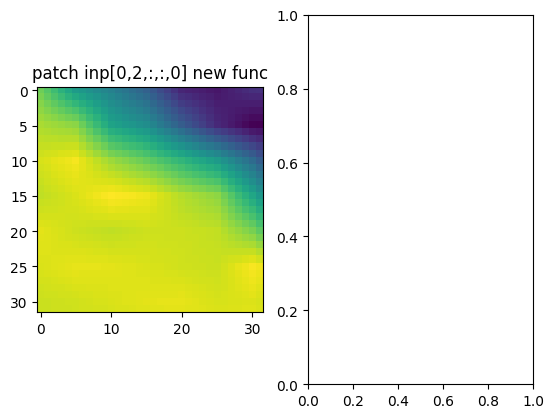

In [20]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 2)
axis[ 0].imshow( tf.squeeze( ejemplo_1[0,2,:,:,0]  ) )
axis[ 0].set_title("patch inp[0,2,:,:,0] new func")

axis[ 1].imshow( tf.squeeze( inp_TiLaLo[0,2,:,:,0]  ) )
axis[ 1].set_title("patch target[0,2,:,:,0] old func")
plt.show()

In [28]:
ejemplo_2=parches_cpu(era5.getVar(),dx=32)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1368 out of 1368 | elapsed:    3.6s finished


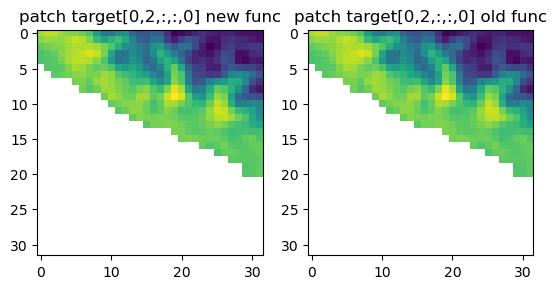

In [29]:
fig, axis = plt.subplots(1, 2)
axis[ 0].imshow( tf.squeeze( ejemplo_2[0,2,:,:,0]  ) )
axis[ 0].set_title("patch target[0,2,:,:,0] new func")

axis[ 1].imshow( tf.squeeze( target_TiLaLo[0,2,:,:,0]  ) )
axis[ 1].set_title("patch target[0,2,:,:,0] old func")
plt.show()

In [68]:
from joblib import delayed, Parallel

def expand_dims(patch): return tf.expand_dims(patch, axis=0)

In [69]:
def parches_cpu(Var, dx=32, n_jobs=8):
    parches = [Var[ dt:(dt+3), dlat:(dlat+32), dlong:(dlong+32)]  for dt in range(0,38) for dlat in range(0,401-dx,dx) for dlong in range(0,101-dx,dx)]
    parches_expandims = Parallel(n_jobs=n_jobs,verbose=0)(delayed(expand_dims)(patch) for patch in parches)
    stack=tf.concat( parches_expandims ,axis=0)
    final_patches = tf.expand_dims(stack, 4)
    return final_patches

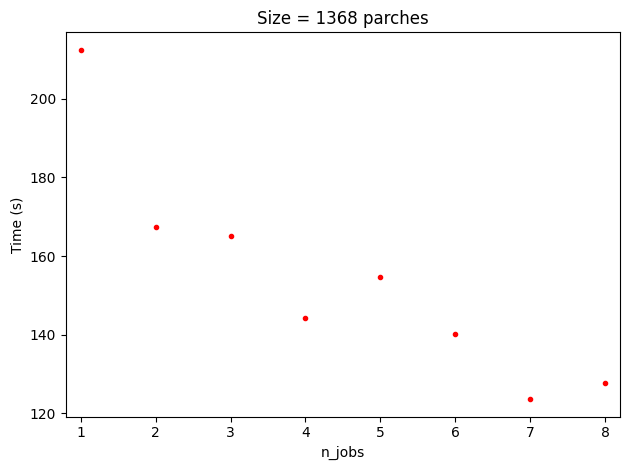

In [71]:
import time 
import numpy as np
import matplotlib.pyplot as plt

max_jobs=8
n_jobs_values = 1 + np.arange(max_jobs)
times= np.zeros( (n_jobs_values.shape[0]))
times.shape

for n,n_jobs in enumerate(n_jobs_values):
    start= time.time()
    result=parches_cpu(g05.getVar(),dx=32, n_jobs=n_jobs)
    times[n]= time.time() - start
np.savetxt('times.txt',times)

times= np.genfromtxt("times.txt")

plt.plot(n_jobs_values, times[:],'.', color='red')
plt.xticks(n_jobs_values)
plt.xlim( [.8, max_jobs + .2])
plt.title( "Size = 1368 parches")
plt.xlabel("n_jobs")
plt.ylabel("Time (s)")
plt.tight_layout()

In [1]:
import multiprocessing

multiprocessing.cpu_count()

4